In [367]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression
from scipy.stats import iqr,zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV

### Reading the Data

In [368]:
concrete_data=pd.read_csv('concrete.csv')
concrete_data.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [369]:
concrete_data.shape

(1030, 9)

## Finding Null values in the dataset

In [370]:
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [371]:
concrete_data.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

### From the above two analysis, we do not have any NULL or missing values in the data. 
We have a total of 1030 entries and 9 attributes

In [372]:
concrete_data.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


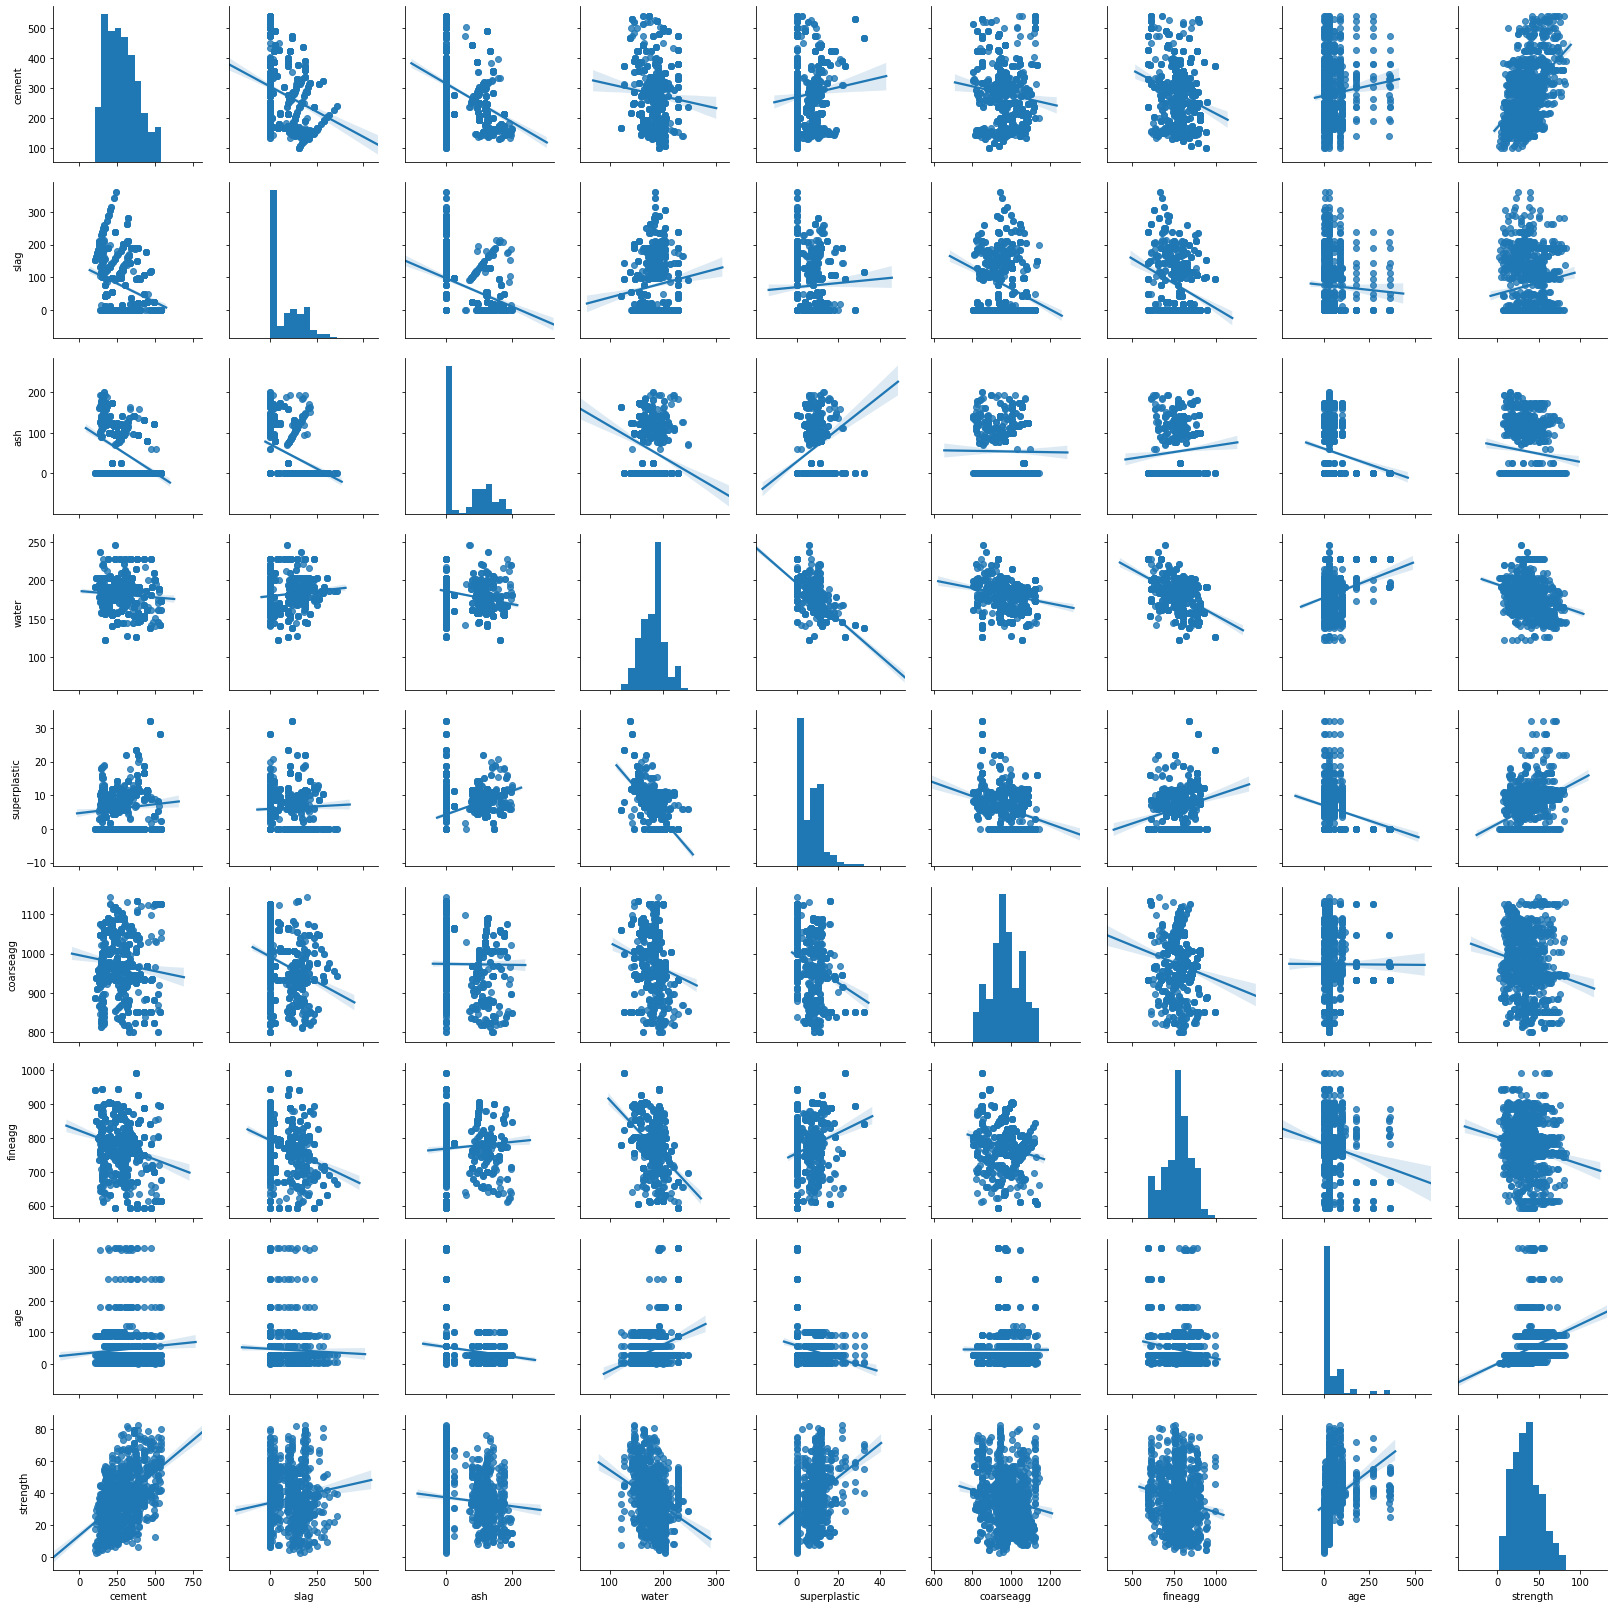

In [373]:
sns.pairplot(concrete_data,kind='reg')

### From the above pairplots, it is clear that water, Coarseagg, FineAgg follows normal distribution whereas Strength and Cement are almost normal with a slight left skew.
### Slag, Ash, Superplastic and Age are clarly left skewed. 

Normalizing the data

In [374]:
concrete_normalized=concrete_data.apply(zscore)

In [375]:
concrete_predictors=concrete_data.drop('strength',axis=1)
concrete_output=concrete_data['strength']
importance=pd.DataFrame()
importance['Features']=concrete_predictors.columns
importance['VIF']=[variance_inflation_factor(concrete_data.values,i) for i in range(concrete_data.shape[1]-1)]
importance

,Features,VIF
0,cement,26.232325
1,slag,4.442518
2,ash,4.560002
3,water,92.504056
4,superplastic,5.519535
5,coarseagg,85.896630
6,fineagg,73.514995
7,age,2.434942


## Using F Regression to find the predictive power of individual variables

In [376]:
f=f_regression(concrete_predictors,concrete_output)
f[1]

array([1.32418331e-65, 1.41356738e-05, 6.75158356e-04, 2.35065465e-21,
       5.13148505e-34, 1.01835134e-07, 6.70411357e-08, 2.10634055e-27])

In [377]:
importance['P Values']=np.round(f[1],6)
importance

,Features,VIF,P Values
0,cement,26.232325,0.000000
1,slag,4.442518,0.000014
2,ash,4.560002,0.000675
3,water,92.504056,0.000000
4,superplastic,5.519535,0.000000
5,coarseagg,85.896630,0.000000
6,fineagg,73.514995,0.000000
7,age,2.434942,0.000000


In [378]:
from sklearn.tree import DecisionTreeRegressor
Decision_Tree_Importance=DecisionTreeRegressor()
Decision_Tree_Importance.fit(concrete_predictors,concrete_output)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [379]:
importance['Importance']=Decision_Tree_Importance.feature_importances_
importance

,Features,VIF,P Values,Importance
0,cement,26.232325,0.000000,0.362036
1,slag,4.442518,0.000014,0.111347
2,ash,4.560002,0.000675,0.010385
3,water,92.504056,0.000000,0.109540
4,superplastic,5.519535,0.000000,0.025662
5,coarseagg,85.896630,0.000000,0.033179
6,fineagg,73.514995,0.000000,0.025754
7,age,2.434942,0.000000,0.322096


In [380]:
corr=np.round(concrete_predictors.corr(),3)

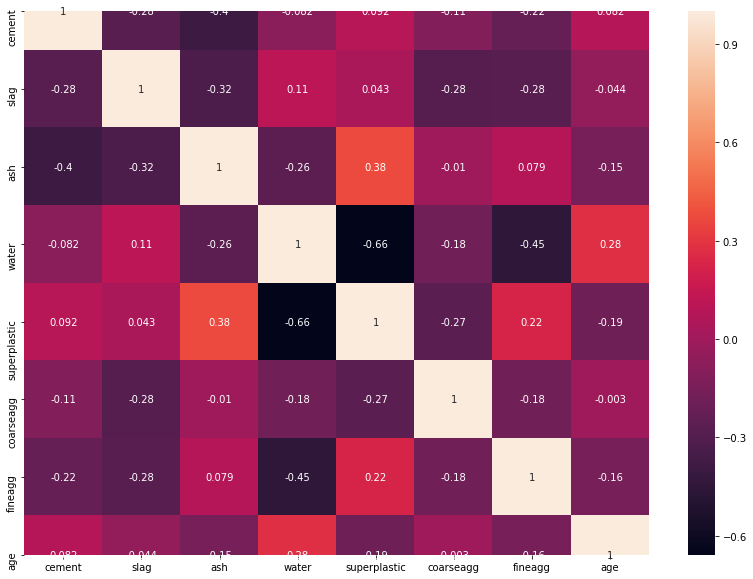

In [381]:
fig,axes=plt.subplots(1,1,figsize=(14,10))
fig=sns.heatmap(corr,annot=True)

### From the above analysis, it is quite evident that Superplastic is correlated with water, with a value of -0.66 in Correlation Matrix. 
The Correlation value is not extremely high, hence creating two DataFrames, one with SuperPlastic Dropped and one withhout dropping any varibales to check how the model performs. If the model performs similarly with dropped attributes, then we can stop considering SuperPlastic for model building. 

### From the above two analysis , it is clear that the attributes Water, Coarseagg and Fineagg is  multicollinear as they have high value of variance inflation factor. 
 That is Water, CoarseAgg and FineAgg can be determined by using other parameters in the data, which is explainanble from the pair plot. 
 The graphs for FineAgg and CoarseAgg are similar which means they both are highly correlated. 
 Similarly, the grpahs for water and Superplastic are similar and hence the correlation. 

### Similarly after the F-regression Test, we obtained extremely low P-values for all the variables and hence all the variables have good explanatory power for predicting the output variable

Here, F regression can also be deceptive as it does not capture non linear relation between the parameters


## Outlier detection

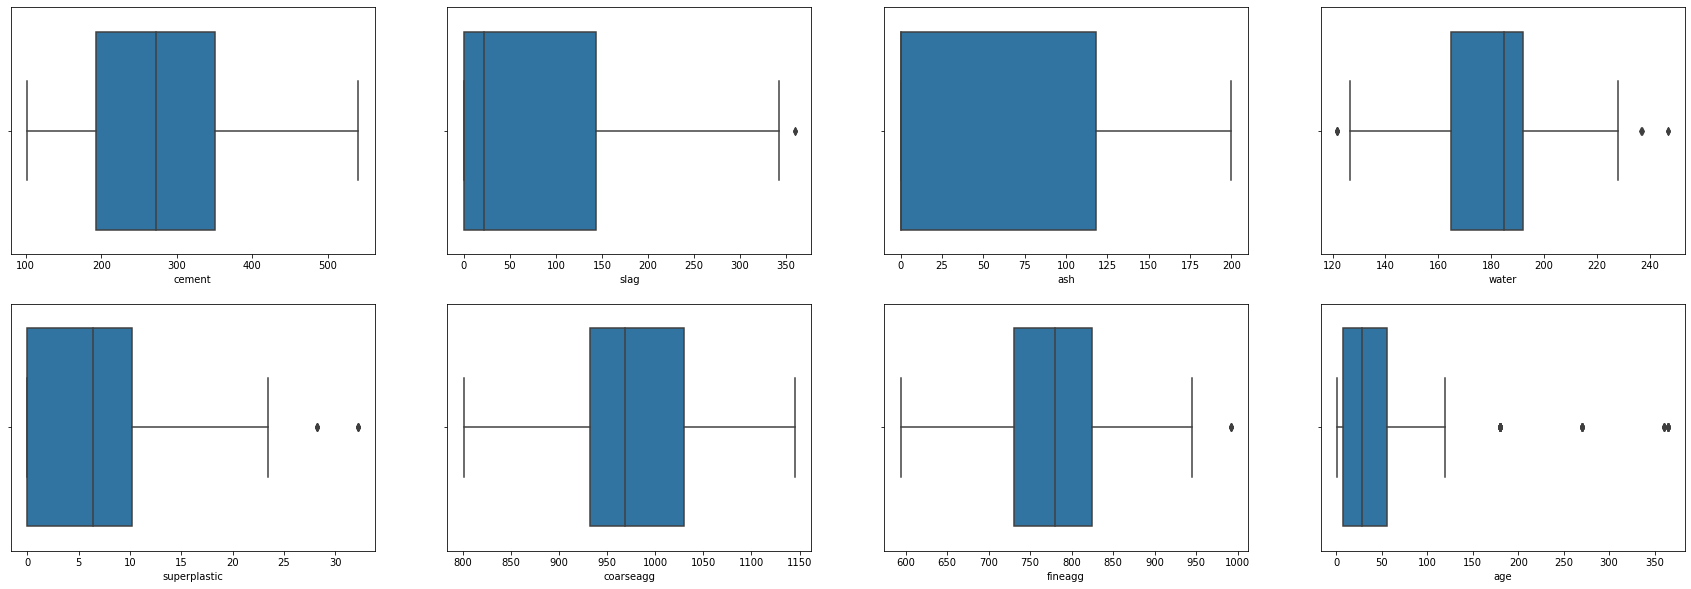

In [382]:
fig,axes=plt.subplots(2,4,figsize=(30,10))
k=0
for i in range(2):
    for j in range(4):
        sns.boxplot(concrete_predictors[concrete_predictors.columns[k]],ax=axes[i,j])
        k=k+1

In [383]:
for i,cname in enumerate(concrete_predictors):
    q75,q25=np.percentile(concrete_predictors[cname],[75,25])
    iqr=np.round(q75-q25,2)
    count1=(concrete_predictors[cname][concrete_predictors[cname]>(q75+(iqr*1.5))].count())
    count2=(concrete_predictors[cname][concrete_predictors[cname]<(q25-(iqr*1.5))].count())
    count=count1+count2
    print('{} has {} outliers. {} before the first quartile and {} above the third quartile'.format(cname,count,count2,count1))

cement has 0 outliers. 0 before the first quartile and 0 above the third quartile
slag has 2 outliers. 0 before the first quartile and 2 above the third quartile
ash has 0 outliers. 0 before the first quartile and 0 above the third quartile
water has 9 outliers. 5 before the first quartile and 4 above the third quartile
superplastic has 10 outliers. 0 before the first quartile and 10 above the third quartile
coarseagg has 0 outliers. 0 before the first quartile and 0 above the third quartile
fineagg has 5 outliers. 0 before the first quartile and 5 above the third quartile
age has 59 outliers. 0 before the first quartile and 59 above the third quartile


## Relation between Attributes


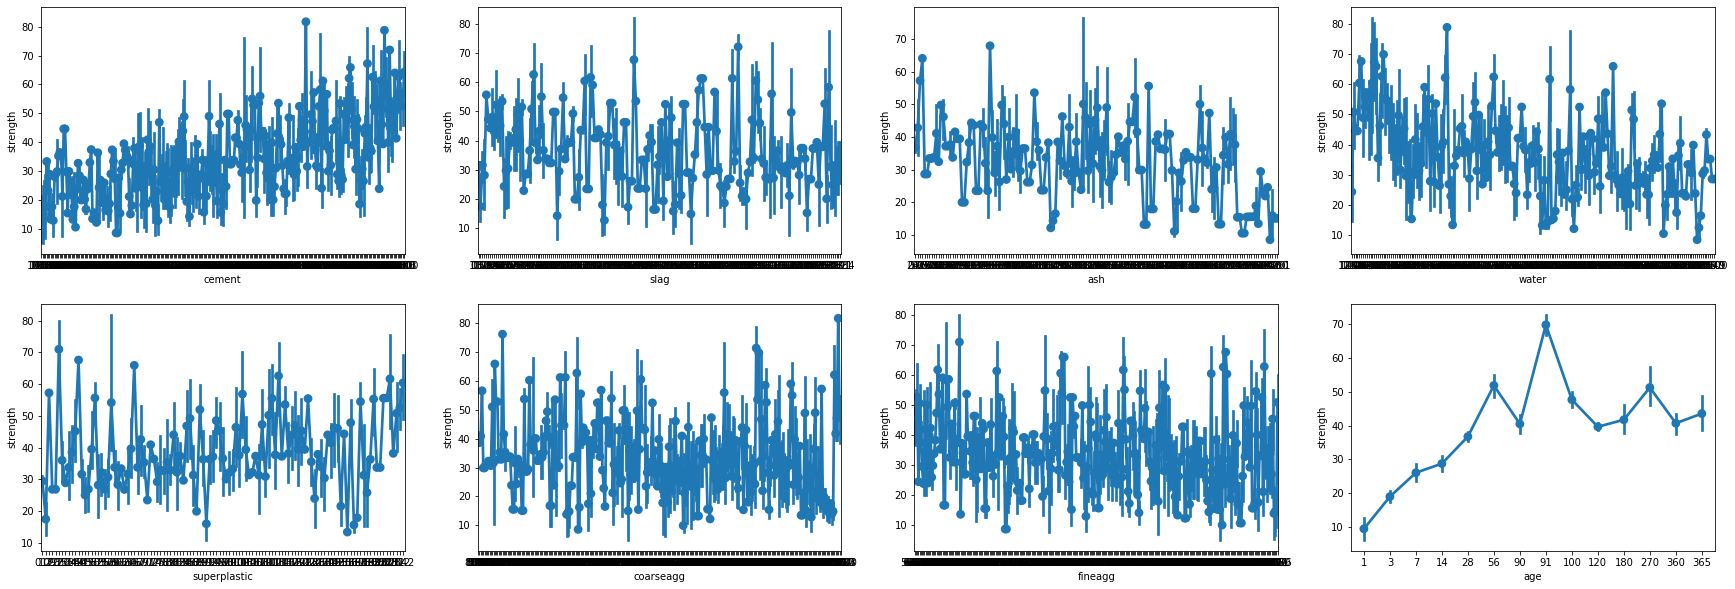

In [384]:
fig,axes=plt.subplots(2,4,figsize=(30,10))
k=0
for i in range(2):
    for j in range(4):
        sns.pointplot(concrete_predictors[concrete_predictors.columns[k]],concrete_output,ax=axes[i,j],linestyles='-')
        k=k+1

### From the above pointplots it is quite evident that 
1. Cement content has a positive relation with the strength. As the cement content inscreases the strength increases accordingly. 
2. Age has a  the content gets aged the strength increases 
3. Similarly Concentration of Ash and Water has a negative impact on strength. 
4. The relation between Ash and Strength is in two clusters and has no linear relation 
5. The relation between Slag and Strength is slightly linear and positive. As the Slag content increases, the Strength also increases slightly. Although most of the data is concentrated around the range of 0 to 50.
6. The Fine Aggregate and Coarse aggregate seem to be influencing the strength in a negative way as for most of the cases, strength decreases on increasing the parameters.They also do not have a linear relation with Strength. 


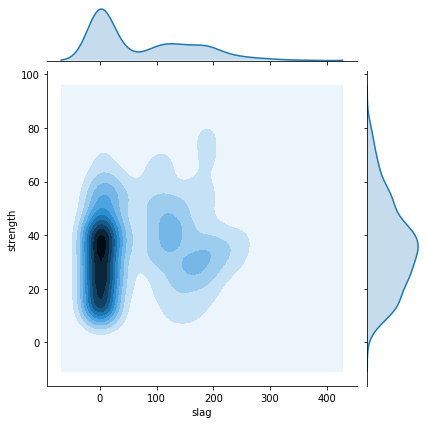

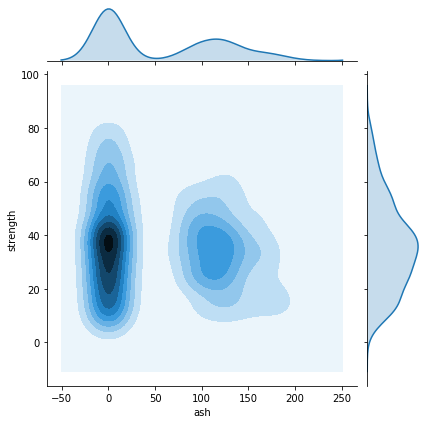

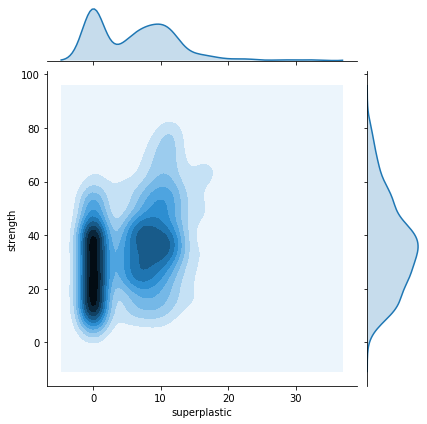

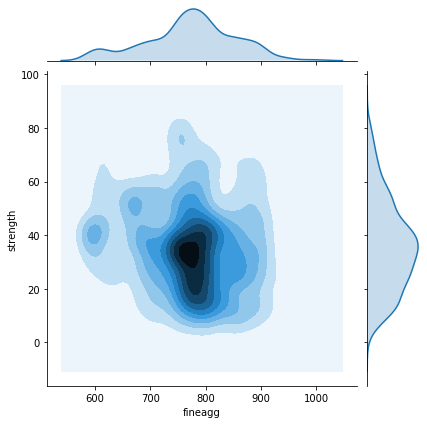

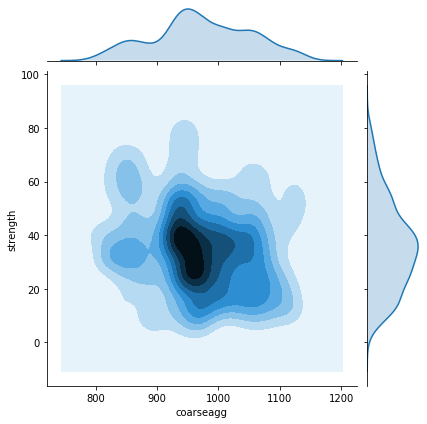

In [385]:
sns.jointplot(concrete_predictors['slag'],concrete_output,kind='kde')
sns.jointplot(concrete_predictors['ash'],concrete_output,kind='kde')
sns.jointplot(concrete_predictors['superplastic'],concrete_output,kind='kde')
sns.jointplot(concrete_predictors['fineagg'],concrete_output,kind='kde')
sns.jointplot(concrete_predictors['coarseagg'],concrete_output,kind='kde')

## Handling Outliers


In [386]:
concrete_pred_outliers=pd.DataFrame()
concrete_pred_outliers=concrete_predictors.copy()
for i,cname in enumerate(concrete_predictors):
    q75,q25=np.percentile(concrete_predictors[cname],[75,25])
    iqr=np.round(q75-q25,2)
    concrete_pred_outliers[cname][concrete_pred_outliers[cname]>q75+(iqr*1.5)]=q75
    concrete_pred_outliers[cname][concrete_pred_outliers[cname]<q25-(iqr*1.5)]=q25


/home/sandheep/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sandheep/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


##### Removing the outliers by rounding them to the nearest quartiles.


#### Splitting the data Using Train,Test,Split.
Since we have few data points, We are splitting the data Into only Train and Test Set. We will have to employ Cross Validation Techniques to evaluate the performance on Validation Dataset

In [387]:
x_train,x_test,y_train,y_test=train_test_split(concrete_pred_outliers,concrete_output,test_size=0.25,random_state=1)

In [388]:
print('Train Dataset has a size of {}'.format(x_train.shape[0]))
print('Test Dataset has a size of {}'.format(x_test.shape[0]))

Train Dataset has a size of 772
Test Dataset has a size of 258


## Using Principal Componenent Analysis to confirm dropping of parameters

In [389]:
pca1=PCA()
pca1=pca1.fit(x_train.apply(zscore))
pca1.explained_variance_ratio_

array([0.27061862, 0.17806703, 0.15986835, 0.1315755 , 0.11901143,
       0.11454727, 0.02179221, 0.00451959])

#### It seems that 6/8 variables can cover 97%% of the variance and 7/8variables cover 99% of the variance. Hence there is a possiblilty for feature reduction by dropping one variable which can be water And/or CoarseAgg from the above analysis. 

In [390]:
x_train_dropped=x_train.drop('coarseagg',axis=1)
x_test_dropped=x_test.drop('coarseagg',axis=1)

## There was no direct way to combine the attributes,hence no feature combining was done


## Analysis the performance of a linear model and model complexity needed

In [391]:
LinearReg=LinearRegression()
LinearReg.fit(x_train_dropped,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [392]:
LinearReg.score(x_train_dropped,y_train)

0.7527870282815027

In [393]:
LinearReg.score(x_test.drop('coarseagg',axis=1),y_test)

0.7409264502485488

Since the linear Model cannot explain well the variations in the data, we will have to go for other models. 

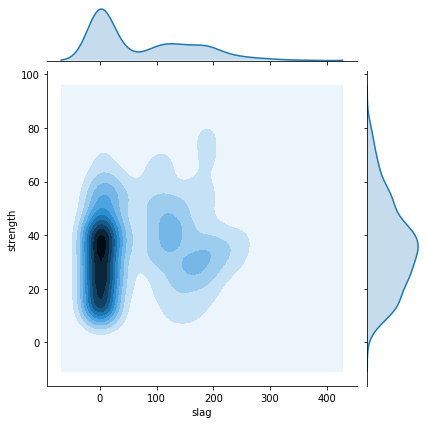

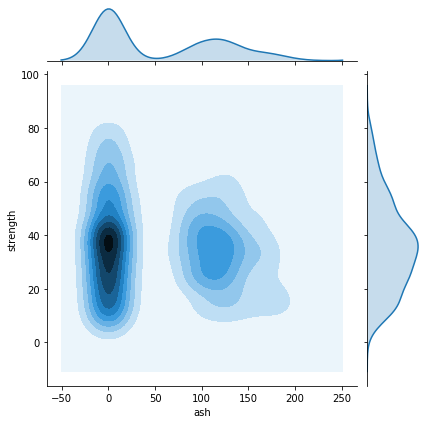

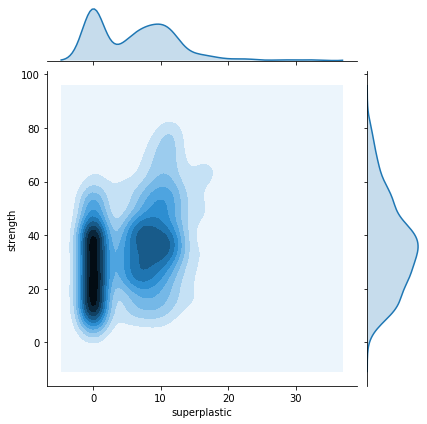

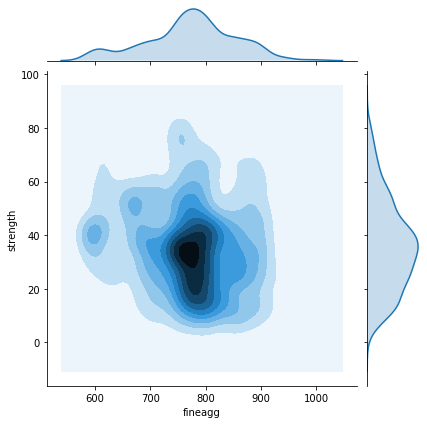

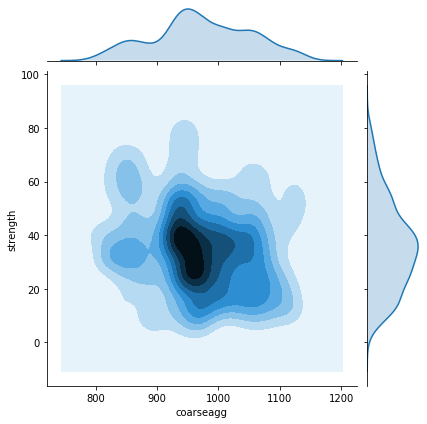

In [394]:
sns.jointplot(concrete_predictors['slag'],concrete_output,kind='kde')
sns.jointplot(concrete_predictors['ash'],concrete_output,kind='kde')
sns.jointplot(concrete_predictors['superplastic'],concrete_output,kind='kde')
sns.jointplot(concrete_predictors['fineagg'],concrete_output,kind='kde')
sns.jointplot(concrete_predictors['coarseagg'],concrete_output,kind='kde')

## From the above two analysis, there are parameters where the KDE Plots overlap.
### Hence we will have to go for a more complex model for better accuracy

## Using Kmeans to find relations

In [395]:
KMRes=pd.DataFrame(columns=['Inertia','Clusters'])
for i in range(1,15):
    KM=KMeans(i,n_init=10)
    KM.fit(x_train_dropped,y_train)
    KMRes=KMRes.append(pd.DataFrame([(KM.inertia_,i)],columns=['Inertia','Clusters']),ignore_index=True)

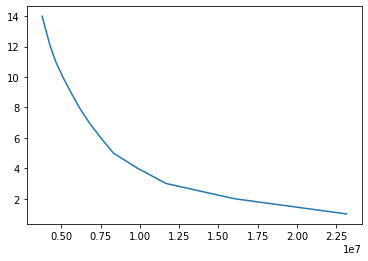

In [396]:
plt.plot(KMRes['Inertia'],KMRes['Clusters'])

Here, we found that 10 is the right number of clusters

KMean=KMeans(n_clusters=10)
KMean.fit(x_train_dropped)

In [397]:
labels=KM.labels_
counts= np.bincount(labels[labels>=0])
print(counts)

[ 53  62  74  38  68  63  59  60  55  26  38  39 111  26]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f144d3bdf10>,
      dtype=object)

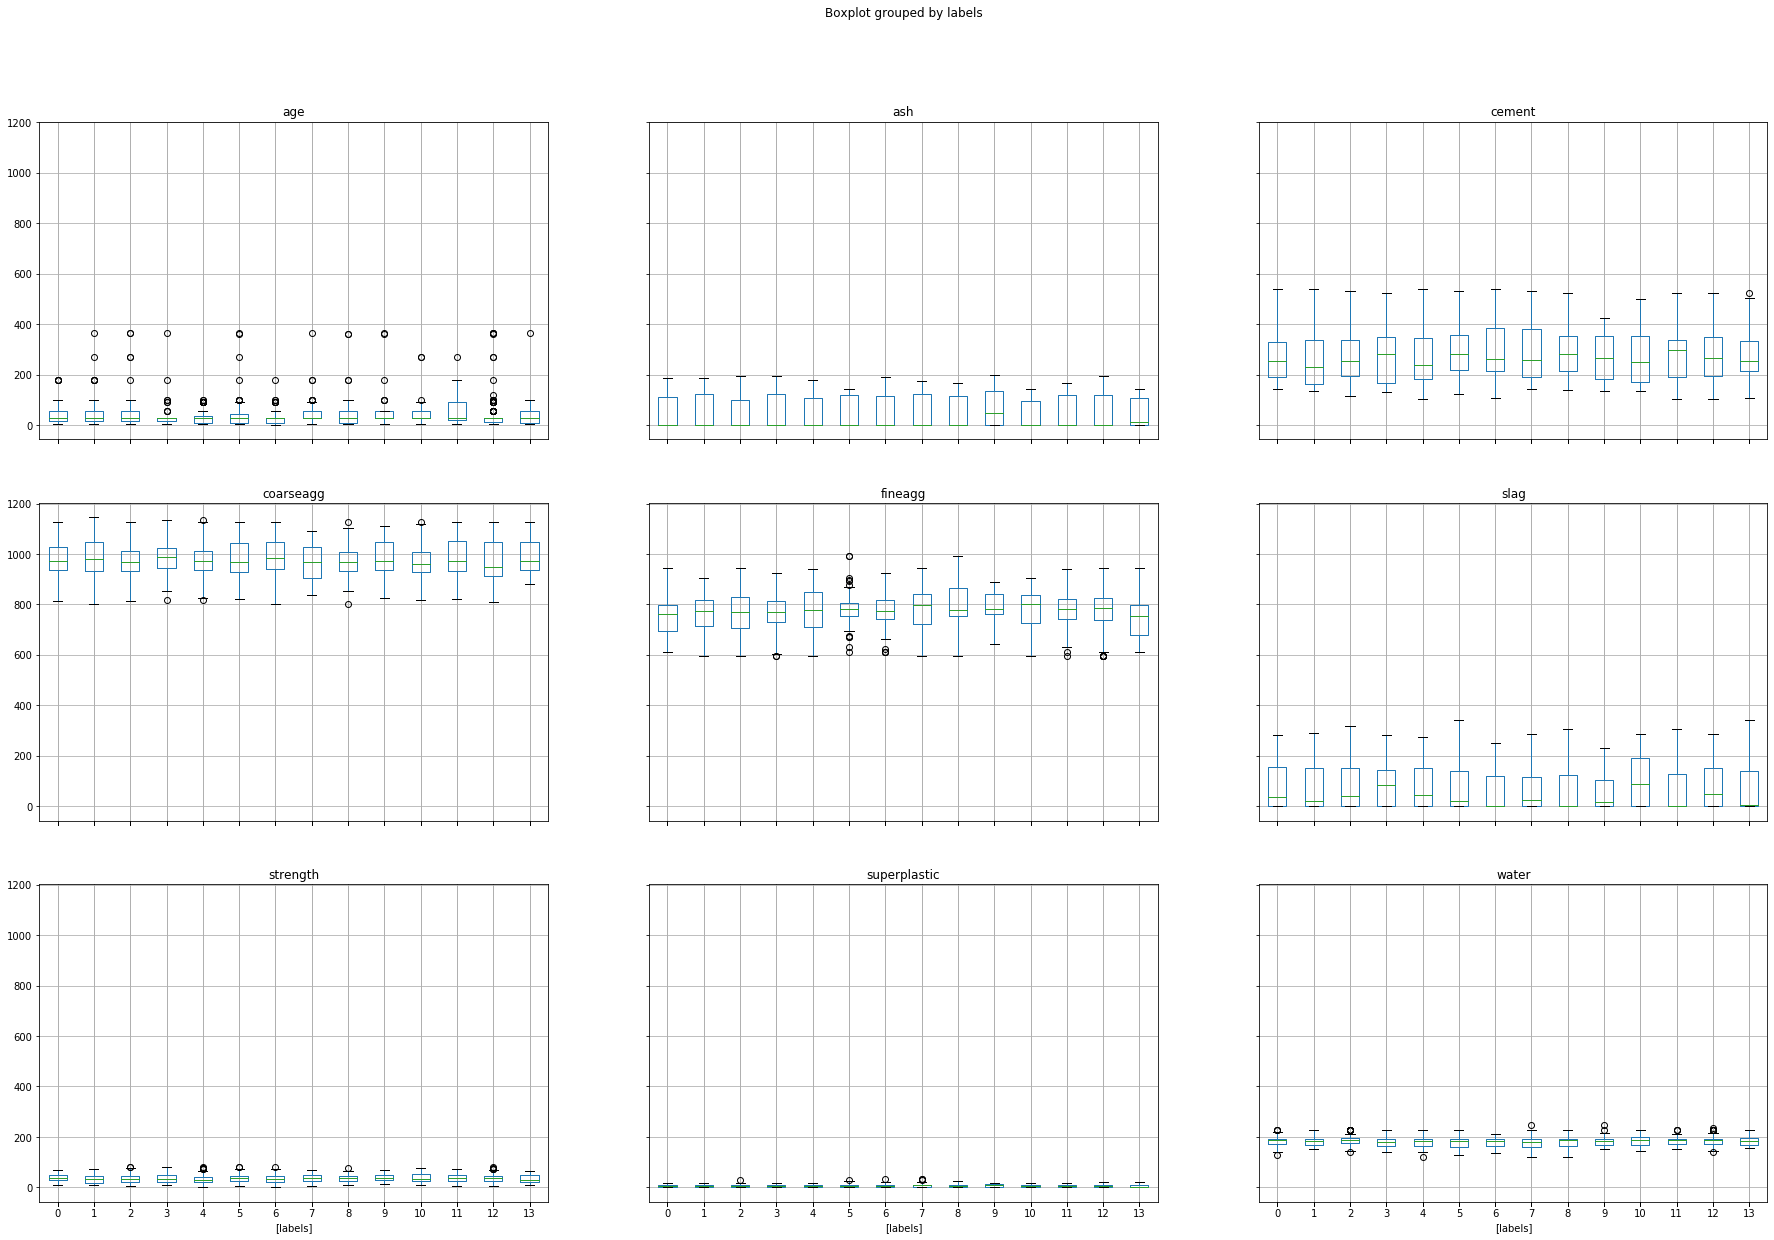

In [398]:
cluster_labels = pd.DataFrame(KM.labels_ , columns = list(['labels']))
cluster_labels['labels'] = cluster_labels['labels'].astype('category')
concrete_data_labels= concrete_data.join(cluster_labels)

concrete_data_labels.boxplot(by = 'labels',  layout=(3,3), figsize=(30, 20))

#### The attributes are weak predictors except for cement. 


## Feature Importance

#### From the above conducted analysis by using the VIF, FRegression and Decision Tree Regressor we have the below table

In [399]:
importance

,Features,VIF,P Values,Importance
0,cement,26.232325,0.000000,0.362036
1,slag,4.442518,0.000014,0.111347
2,ash,4.560002,0.000675,0.010385
3,water,92.504056,0.000000,0.109540
4,superplastic,5.519535,0.000000,0.025662
5,coarseagg,85.896630,0.000000,0.033179
6,fineagg,73.514995,0.000000,0.025754
7,age,2.434942,0.000000,0.322096


From the above table, Cement, CoarseAgg and Age are the top 3 important parameters according to Decision Tree Regressor Test.

It is also an outcome of the Fregression that all the parameters are able to predict the strength indidually and hence they have strong predcitive power.

### Here, Ash,FineAgg, CoarseAgg, SuperPlastic has very low importance value based on the test. Hence there can be a possibility to remove them during upcomg stages

### Models

Based on the data
Linear Regression, 
Ridge,
Lasso,
Support Vector Machines,
Decision Tree Regressor,
are possible options for models

Logistic Regression - Used for Classification
Naive Bayes- Used for Classification
KNN - Used for Classification


#### Linear Regression

In [400]:
LinearReg=LinearRegression()
LinearReg.fit(x_train_dropped,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [401]:
LinearReg.score(x_train_dropped,y_train)

0.7527870282815027

In [402]:
scoreLR=LinearReg.score(x_test_dropped,y_test)

##### Dropping the above identified variables to check for improved performance

In [403]:
LinearRegTuned=LinearRegression()
x_train_dropped_tuned=x_train_dropped.drop(['ash','fineagg','superplastic'],axis=1)
x_test_dropped_tuned=x_test_dropped.drop(['ash','fineagg','superplastic'],axis=1)

In [404]:
LinearRegTuned.fit(x_train_dropped_tuned,y_train)
scoreLRD=LinearRegTuned.score(x_test_dropped_tuned,y_test)

In [405]:
Performance=pd.DataFrame(columns=['Model','Performance'])
temp=pd.DataFrame([('Linear Regression',scoreLR*100)],columns=['Model','Performance'])
Performance=Performance.append(pd.DataFrame([('Linear Regression',scoreLR*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645


In [406]:
Performance=Performance.append(pd.DataFrame([('Linear Regression Dropped',scoreLRD*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547


Dropping the other parameters reduces the efficiency, hence dropping only one parameter to get best efficiency in Linear regression

#### Ridge Regression

In [407]:
RidgeRes=pd.DataFrame(columns=['Alpha','Score'])
alph=0.01
for i in range(10000):
    RidgeReg=Ridge(alpha=alph,solver='auto',random_state=1)
    RidgeReg.fit(x_train_dropped,y_train)
    scoreRidge=RidgeReg.score(x_test_dropped,y_test)
    tempRidge=pd.DataFrame([(alph,scoreRidge)],columns=['Alpha','Score'])
    RidgeRes=RidgeRes.append(tempRidge)
    alph=alph+0.01

In [408]:
RidgeRes['Alpha'][RidgeRes['Score']==RidgeRes['Score'].max()]
score=RidgeRes['Score'].max()

In [409]:
Performance=Performance.append(pd.DataFrame([('Ridge Regression',RidgeRes['Score'].max()*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712


##### Dropping columns in Ridge

In [410]:
RidgeRegD=Ridge(alpha=0.01,solver='auto',random_state=1)
RidgeRegD.fit(x_train_dropped_tuned,y_train)
scoreRidgeD=RidgeRegD.score(x_test_dropped_tuned,y_test)
scoreRidgeD

0.6966954668028198

In [411]:
Performance=Performance.append(pd.DataFrame([('Ridge Regression Dropped',scoreRidgeD*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547


#### Lasso Regression

In [412]:
LassoRes=pd.DataFrame(columns=['Alpha','Score'])
alph=0.01
for i in range(10000):
    LassoReg=Lasso(alpha=alph,random_state=1)
    LassoReg.fit(x_train_dropped,y_train)
    scoreLasso=LassoReg.score(x_test_dropped,y_test)
    tempLasso=pd.DataFrame([(alph,scoreLasso)],columns=['Alpha','Score'])
    LassoRes=LassoRes.append(tempLasso)
    alph=alph+0.01

In [413]:
LassoRes['Alpha'][LassoRes['Score']==LassoRes['Score'].max()]

0    3.53
Name: Alpha, dtype: float64

In [414]:
temp=pd.DataFrame([('Lasso Regression',LassoRes['Score'].max()*100)],columns=['Model','Performance'])
Performance=Performance.append(temp)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
0,Lasso Regression,74.327175


##### Dropping columns in Lasso

In [415]:
LassoRegD=Lasso(alpha=0.01,random_state=1)
LassoRegD.fit(x_train_dropped_tuned,y_train)
scoreLassoD=LassoRegD.score(x_test_dropped_tuned,y_test)
scoreLassoD

0.6966949792685975

In [416]:
Performance=Performance.append(pd.DataFrame([('Lasso Regression Dropped',scoreLassoD*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498


### Gradient Boosting regressor

In [417]:
GBRRes=pd.DataFrame(columns=['Estimators','TrainScore','TestScore'])
for i in range(50,120):
    GBReg= GradientBoostingRegressor(n_estimators=i,random_state=1)
    GBReg.fit(x_train_dropped,y_train)
    scoreGBR=GBReg.score(x_test_dropped,y_test)
    tempGBR=pd.DataFrame([(i,GBReg.score(x_train_dropped,y_train),scoreGBR)],columns=['Estimators','TrainScore','TestScore'])
    GBRRes=GBRRes.append(tempGBR)

In [418]:
GBRRes['Estimators'][GBRRes['TestScore']==GBRRes['TestScore'].max()]

0    119
Name: Estimators, dtype: object

In [419]:
GBReg.score(x_test_dropped,y_test)

0.8962434084865243

In [420]:
Performance=Performance.append(pd.DataFrame([('Gradient Boosting Regressor Tuned',GBReg.score(x_test_dropped,y_test)*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341


Dropping the variables with nestimators=119

In [421]:
GBRegD= GradientBoostingRegressor(n_estimators=119,random_state=1)
GBRegD.fit(x_train_dropped_tuned,y_train)
Performance=Performance.append(pd.DataFrame([('Gardient Boosting Regressor Tuned And Dropped',GBRegD.score(x_test_dropped_tuned,y_test)*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341
7,Gardient Boosting Regressor Tuned And Dropped,88.940526


### Bagging Regressor

In [422]:
BRes=pd.DataFrame(columns=['Estimators','TrainScore','TestScore'])
for i in range(50,120):
    BReg= BaggingRegressor(n_estimators=i,random_state=1)
    BReg.fit(x_train_dropped,y_train)
    scoreBR=BReg.score(x_test_dropped,y_test)
    tempBR=pd.DataFrame([(i,BReg.score(x_train_dropped,y_train),scoreBR)],columns=['Estimators','TrainScore','TestScore'])
    BRes=BRes.append(tempBR)

In [423]:
BRes['Estimators'][BRes['TestScore']==BRes['TestScore'].max()]

0    58
Name: Estimators, dtype: object

In [424]:
BReg.score(x_test_dropped,y_test)

0.9106310031472306

In [425]:
Performance=Performance.append(pd.DataFrame([('Bagging Regressor Tuned',BReg.score(x_test_dropped,y_test)*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341
7,Gardient Boosting Regressor Tuned And Dropped,88.940526
8,Bagging Regressor Tuned,91.063100


Dropping the variables with nestimators=50

In [426]:
BRegD= BaggingRegressor(n_estimators=50,random_state=1)
BRegD.fit(x_train_dropped_tuned,y_train)
Performance=Performance.append(pd.DataFrame([('Bagging Regressor Tuned And Dropped',BRegD.score(x_test_dropped_tuned,y_test)*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341
7,Gardient Boosting Regressor Tuned And Dropped,88.940526
8,Bagging Regressor Tuned,91.063100
9,Bagging Regressor Tuned And Dropped,90.097758


### Decision Tree Regressor

In [427]:
DecisionTreeReg=DecisionTreeRegressor(random_state=1)
DecisionTreeReg.fit(x_train_dropped,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [428]:
DecisionTreeReg.score(x_test_dropped,y_test)

0.8751750014277377

In [429]:
Performance=Performance.append(pd.DataFrame([('Decision Tree',DecisionTreeReg.score(x_test_dropped,y_test)*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341
7,Gardient Boosting Regressor Tuned And Dropped,88.940526
8,Bagging Regressor Tuned,91.063100
9,Bagging Regressor Tuned And Dropped,90.097758


#### Dropping the parameters with low importance to check for imporved performance

In [430]:
DecisionTreeRegD=DecisionTreeRegressor(random_state=1)
DecisionTreeRegD.fit(x_train_dropped_tuned,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [431]:
DecisionTreeRegD.score(x_test_dropped_tuned,y_test)

0.8584595116108366

In [432]:
Performance=Performance.append(pd.DataFrame([('Decision Tree Dropped',DecisionTreeRegD.score(x_test_dropped_tuned,y_test)*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341
7,Gardient Boosting Regressor Tuned And Dropped,88.940526
8,Bagging Regressor Tuned,91.063100
9,Bagging Regressor Tuned And Dropped,90.097758


### Random Forest Regressor

In [433]:
RFReg = RandomForestRegressor(n_estimators=50,random_state=1)
RFReg.fit(x_train_dropped,y_train)
RFRes=pd.DataFrame(columns=['Estimators','TrainScore','TestScore'])
for i in range(50,120):
    RFReg=RandomForestRegressor(n_estimators=i,random_state=1)
    RFReg.fit(x_train_dropped,y_train)
    scoreRF=RFReg.score(x_test_dropped,y_test)
    tempRF=pd.DataFrame([(i,RFReg.score(x_train_dropped,y_train),scoreRF)],columns=['Estimators','TrainScore','TestScore'])
    RFRes=RFRes.append(tempRF)

In [434]:
RFRes['Estimators'][RFRes['TestScore']==RFRes['TestScore'].max()]

0    56
Name: Estimators, dtype: object

In [435]:
RFReg.score(x_test_dropped,y_test)

0.9104462035219211

In [436]:
Performance=Performance.append(pd.DataFrame([('Random Forest Regressor Tuned',RFReg.score(x_test_dropped,y_test)*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341
7,Gardient Boosting Regressor Tuned And Dropped,88.940526
8,Bagging Regressor Tuned,91.063100
9,Bagging Regressor Tuned And Dropped,90.097758


Dropping the variables with nestimators=114

In [437]:
RFRegD= RandomForestRegressor(n_estimators=114,random_state=1)
RFRegD.fit(x_train_dropped_tuned,y_train)
Performance=Performance.append(pd.DataFrame([('Random Forest Regressor Tuned And Dropped',RFRegD.score(x_test_dropped_tuned,y_test)*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341
7,Gardient Boosting Regressor Tuned And Dropped,88.940526
8,Bagging Regressor Tuned,91.063100
9,Bagging Regressor Tuned And Dropped,90.097758


## Out of all the models, Bagging Regressor seems to have the highest accuracy for the model. 
 Hence trying out Hyper Parameter Tuning using Grid Search and RandomCV search on Bagging Regressor by just dropping one attribute "CoarseAgg"

## Using RandomizedSearchCV on Random Forest Regressor

In [438]:
RFRegD.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 114,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

## Using randomized Search CV to find the best hyper parameters

In [439]:
parameter={'bootstrap': [True],
 'n_estimators': np.arange(50,200),
 'max_features':['auto', 'log2'],
 'oob_score': [True,False],
 'warm_start': [True,False]}

parameter

{'bootstrap': [True],
 'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 195, 196, 197, 198, 199]),
 'max_features': ['auto', 'log2'],
 'oob_score': [True, False],
 'warm_start': [True, False]}

In [440]:
random_search = RandomizedSearchCV(estimator = RFRegD, param_distributions= parameter,cv = 3, verbose=2, random_state=1,return_train_score=True)

In [441]:
random_search.fit(x_train_dropped,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] warm_start=False, oob_score=True, n_estimators=165, max_features=log2, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  warm_start=False, oob_score=True, n_estimators=165, max_features=log2, bootstrap=True, total=   0.3s
[CV] warm_start=False, oob_score=True, n_estimators=165, max_features=log2, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  warm_start=False, oob_score=True, n_estimators=165, max_features=log2, bootstrap=True, total=   0.3s
[CV] warm_start=False, oob_score=True, n_estimators=165, max_features=log2, bootstrap=True 
[CV]  warm_start=False, oob_score=True, n_estimators=165, max_features=log2, bootstrap=True, total=   0.3s
[CV] warm_start=False, oob_score=False, n_estimators=108, max_features=auto, bootstrap=True 
[CV]  warm_start=False, oob_score=False, n_estimators=108, max_features=auto, bootstrap=True, total=   0.2s
[CV] warm_start=False, oob_score=False, n_estimators=108, max_features=auto, bootstrap=True 
[CV]  warm_start=False, oob_score=False, n_estimators=108, max_features=auto, bootstrap=True, total=   0.2s
[CV] warm_start=False, oob_score=False, n_estimators=108, max_features=auto, bootstrap=True 
[CV]  warm_start=False, oob_score=False, n_estimators=108, max_features=auto, bootstrap=True, total=   0.2s
[CV] warm_start=True, oob_score=True, n_estimators=174, max_features=log2, bootstrap=True 


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=114,
                                                   n_jobs=None, oob_score=False,
                                                   random_state=...


In [442]:
random_search.best_params_

{'warm_start': False,
 'oob_score': False,
 'n_estimators': 108,
 'max_features': 'auto',
 'bootstrap': True}

### Recreating the Random Forest Regressor with the chosen parameters

In [444]:
RFHTModel=random_search.best_estimator_
RFHTModel.score(x_test_dropped,y_test)

0.9107890420199735

In [445]:
BRegHT= RandomForestRegressor(random_state=1,oob_score=False,bootstrap=True,n_estimators=108,warm_start=False)
BRegHT.fit(x_train_dropped_tuned,y_train)
scoreBRHT=BRegHT.score(x_test_dropped_tuned,y_test)

In [446]:
scoreBRHT

0.901579092792358

In [447]:
Performance=Performance.append(pd.DataFrame([('Random Forest Regressor Hyper Tuned',scoreBRHT*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341
7,Gardient Boosting Regressor Tuned And Dropped,88.940526
8,Bagging Regressor Tuned,91.063100
9,Bagging Regressor Tuned And Dropped,90.097758


The performance of the model has reduced a bit on using Hyper Parameter tuning with Random Forest Regressor.

#### Random Forest Regressor seems to be giving the best results without Hyper Parameter Tuning

## Using RandomizedSearchCV on Bagging Regressor which has similar prediction accuracy

In [448]:
BReg.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 119,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

## Using randomized Search CV to find the best hyper parameters

In [449]:
n_estimator=np.arange(50,151)
n_estimator


array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150])

In [450]:
parameter={
 'bootstrap': [True],
 'bootstrap_features': [True,False],
 'n_estimators':np.arange(50,151),
 'oob_score': [True,False]}
parameter

{'bootstrap': [True],
 'bootstrap_features': [True, False],
 'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
         76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
         89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150]),
 'oob_score': [True, False]}

In [451]:
random_search = RandomizedSearchCV(estimator = BReg, param_distributions= parameter,cv = 3, verbose=2, random_state=1,return_train_score=True)

In [452]:
random_search.fit(x_train_dropped,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] oob_score=True, n_estimators=129, bootstrap_features=False, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  oob_score=True, n_estimators=129, bootstrap_features=False, bootstrap=True, total=   0.3s
[CV] oob_score=True, n_estimators=129, bootstrap_features=False, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  oob_score=True, n_estimators=129, bootstrap_features=False, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=129, bootstrap_features=False, bootstrap=True 
[CV]  oob_score=True, n_estimators=129, bootstrap_features=False, bootstrap=True, total=   0.3s
[CV] oob_score=True, n_estimators=81, bootstrap_features=True, bootstrap=True 
[CV]  oob_score=True, n_estimators=81, bootstrap_features=True, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=81, bootstrap_features=True, bootstrap=True 
[CV]  oob_score=True, n_estimators=81, bootstrap_features=True, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=81, bootstrap_features=True, bootstrap=True 
[CV]  oob_score=True, n_estimators=81, bootstrap_features=True, bootstrap=True, total=   0.2s
[CV] oob_score=True, n_estimators=136, bootstrap_features=False, bootstrap=True 
[CV]  oob_score=True, n_estimators=136, bootstrap_features=False, bootstrap=True, total=   0.3s
[CV] oob_score=True, n_estimato

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BaggingRegressor(base_estimator=None,
                                              bootstrap=True,
                                              bootstrap_features=False,
                                              max_features=1.0, max_samples=1.0,
                                              n_estimators=119, n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'bootstrap': [True],
                                        'bootstrap_fe...
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 13

In [453]:
random_search.best_params_

{'oob_score': True,
 'n_estimators': 97,
 'bootstrap_features': False,
 'bootstrap': True}

### Recreating the Bagging Regressor with the chosen parameters

In [454]:
BRegHT= BaggingRegressor(n_estimators=95,random_state=1,oob_score=False,bootstrap_features=False,bootstrap=True)
BRegHT.fit(x_train_dropped,y_train)
scoreBRHT=BRegHT.score(x_test_dropped,y_test)

In [455]:
scoreBRHT

0.9116614711956713

In [456]:
Performance=Performance.append(pd.DataFrame([('Bagging Regressor Hyper Tuned',BRegHT.score(x_test_dropped,y_test)*100)],columns=['Model','Performance']),ignore_index=True)
Performance

,Model,Performance
0,Linear Regression,74.092645
1,Linear Regression Dropped,69.669547
2,Ridge Regression,74.097712
3,Ridge Regression Dropped,69.669547
4,Lasso Regression,74.327175
5,Lasso Regression Dropped,69.669498
6,Gradient Boosting Regressor Tuned,89.624341
7,Gardient Boosting Regressor Tuned And Dropped,88.940526
8,Bagging Regressor Tuned,91.063100
9,Bagging Regressor Tuned And Dropped,90.097758


The performance of the model has slightly increased. 

## Conclusion

Out of all the models, after applying hyper parameter tuning and different featurization techniques Bagging Regressor has the maximum accuracy, followed by Random Forest Regressor